In [26]:
import pygsp
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import scipy
import pyshtools
from deepsphere.utils import healpix_graph
import pickle
import sys

In [27]:
from pygsp.graphs import SphereHealpix

# 1) Initial guess on the kernel width

First, for each HEALPix resolution, we set the kernel width to be such that, for a fixed number of neighbors, the minimum non-null weight $$w_{ij} = exp\{log\frac{1}{2}(\frac{||x_i-x_j||}{t})^2 \}$$ equals $0.1$. We do so because we empirically observe what we think to be a "good" distribution of the weights: fully and equally covering the significative range $(0.1, 1)$. We fix the number of neighbors to 50 since we expect to use as number of neighbors values close to 50 (form 8 to 100 max). Such kernel widths are stored in the following dictionary:

In [28]:
opt_std =  {1:1.097324009878543,
            2:1.097324042581347,
            4: 0.5710655156439823,
            8: 0.28754191240507265,
            16: 0.14552024595543614,
            32: 0.07439700765663292,
            64: 0.03654101726025044,
            128: 0.018262391329213392,
            256: 0.009136370875837834,
            512: 0.004570016186845779,
            1024: 0.0022857004460788742,}

It's easy to check that these are actually the weights we were looking for:

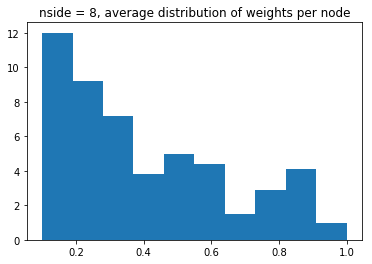

nside=8, minimum non-null weight: 0.10000000000000006


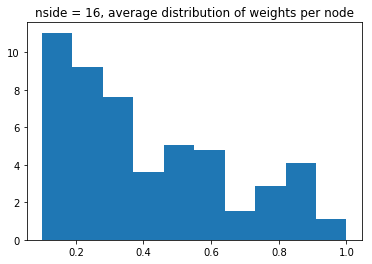

nside=16, minimum non-null weight: 0.10000000000000006


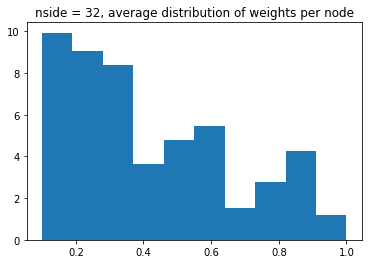

nside=32, minimum non-null weight: 0.10000000000000006


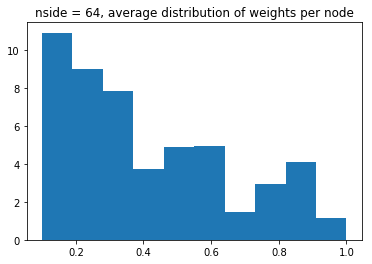

nside=64, minimum non-null weight: 0.10000000000000006


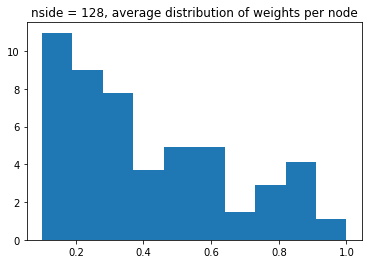

nside=128, minimum non-null weight: 0.10000000000000006


In [7]:
def kernel(distances, t):
        cst = np.log(0.5)
        weights = np.exp(cst*(distances/t)**2).flatten()
        return weights, np.min(weights)


for nside in 2**np.arange(3,8):
    sphere = SphereHealpix(nside=nside, n_neighbors=50, kernel_width=opt_std[nside])
    weights, m = kernel(sphere.distances, opt_std[nside])
    npix = 12*nside**2
    nbins=10
    plt.hist(weights, bins=nbins, weights=np.ones(len(weights))/npix);
    plt.title("nside = {}, average distribution of weights per node".format(nside))
    plt.show()
    print("nside={}, minimum non-null weight: {}".format(nside, m))

# 2) Grid search on kernel width
For different nsides, for different number of neighbors, we perform a grid search on the kernel width around the initial guess made above. We propose to use the kernel width that numerically minimizes the corresponding equivariance error.

In [29]:
# setting matplotlib parameters
plt.rcParams['figure.figsize'] = (17, 5)  
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

In [30]:
degree_step = {
            32: 10,
            64: 10,
            128: 50,
            256: 50,
            512: 100,
            1024: 200,    
}

class HiddenPrints:
    """Necessary since healpy prints a lot of useless stuff"""
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = None

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout
   

In [31]:
# functions necessary to calculate the equivariance error

def rotate_NEST(hmap, rot):
    return hp.reorder(rot.rotate_map_alms(hp.reorder(hmap, n2r=True)), r2n=True)


def _equivariance_error(hmap, max_iter, _filter, lmax, nside):
    """Calculates the equivariance error on one signal only
    as average of max_iter random rotations
    
    hmap is in NEST ordering"""

    
    angles = np.random.uniform(low=0, high=360, size=(max_iter, 3))
    norm = np.zeros(max_iter)
    
    for i, [alpha, beta, gamma] in enumerate(angles):
      
        rot = hp.rotator.Rotator(rot=[alpha, beta, gamma])
        R_hmap = rotate_NEST(hmap, rot)
        FR_hmap = _filter(R_hmap)
        # ------ first filter, then rotate ------
        F_hmap = _filter(hmap)
        RF_hmap = rotate_NEST(F_hmap, rot)
        norm[i] = np.linalg.norm(RF_hmap-FR_hmap)
            
    filtered_norm = np.linalg.norm(F_hmap)      
    return np.mean(norm)/filtered_norm


def equivariance_error(max_iter, _filter, lmax, nside, degree=None):
    """Calculates the equivariance error on max_iter signals
    with the same power spectrum as average of N random rotations each"""
   
    N = 5
    np.random.seed(seed=1994)
    degrees = np.arange(lmax+1, dtype=float)

    degrees[0] = np.inf

    power = degrees**(-3) 
    if degree is not None:
        assert degree < lmax+1
        power = np.zeros(lmax+1)
        power[degree] = 1
    norm = np.zeros(max_iter)
    for i in range(max_iter):
        hmap = hp.sphtfunc.synfast(power, nside=nside)  ## this is RING ORDERED
        hmap = hp.reorder(hmap, r2n=True)
        norm[i] = _equivariance_error(hmap, N, _filter, lmax, nside)
    return np.mean(norm)


In [32]:
nsides = [32, 64]#, 128, 256, 512]# 1024]
neighbors_list = [8, 20, 40]
equiv_error = dict()
opt = dict()
for n_neighbors in neighbors_list:
    opt[n_neighbors] = dict()

Here we calculate the equivariance error
* for different nsides
* for different n_neighbors

To do so we use a randomly generated __red noise__ `power = degrees**(-3)`. Different choices could be made. we sample diferent kernel widths between `min_std = opt_std[nside]/10` and `max_std = opt_std[nside]*10`. We observe that for smaller kernel widths the equivariance error goes to 0, since the graph becomes disconnected and the laplacian becomes the null matrix, that obviouvsly has a zero equivariance error.

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
nside=32, best kernel = 0.024996042676954985
nside=32, best kernel = 0.03185183192481174
nside=32, best kernel = 0.040587992670608114


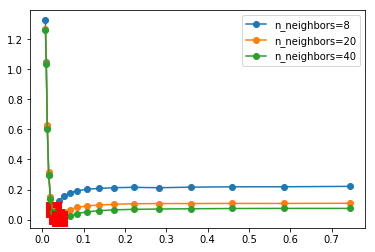

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
nside=64, best kernel = 0.012277117799040067
nside=64, best kernel = 0.015644424107847475
nside=64, best kernel = 0.019935298306361107


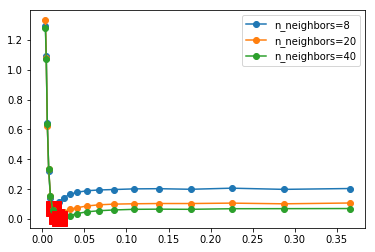

In [13]:
for nside in nsides:
    equiv_error[nside] = dict()
    
    # generating hmaps (red noise)
    lmax = 3*nside-1
    degrees = np.arange(lmax+1, dtype=float)
    degrees[0] = np.inf
    power = degrees**(-3)  # red noise
    hmap = hp.sphtfunc.synfast(power, nside=nside)
    hmap = hp.pixelfunc.reorder(hmap, r2n=True)

    # std deviations to try
    min_std = opt_std[nside]/10
    max_std = opt_std[nside]*10
    kernels = np.logspace(np.log10(min_std), np.log10(max_std), 20)

    for n_neighbors in [8, 20, 40]:
        
        equiv_error[nside][n_neighbors] = np.empty(len(kernels))
        for i, kernel_width in enumerate(kernels):

            sphere = SphereHealpix(nside=nside, nest=True, n_neighbors=n_neighbors, lap_type='combinatorial', kernel_width=kernel_width)
            # WARNING: healpix graph is in NEST ordering
            HKGL_filter = sphere.L

            def diffuse_HKGL(x):
                """x is in NEST order, must return result in NEST order"""
                return HKGL_filter@x

            with HiddenPrints():
                equiv_error[nside][n_neighbors][i] = _equivariance_error(hmap, 5, diffuse_HKGL, lmax, nside);

            del(sphere)

        plt.plot(kernels, equiv_error[nside][n_neighbors], 'o-', label="n_neighbors={}".format(n_neighbors))
        j = np.argmin(equiv_error[nside][n_neighbors])
        plt.plot(kernels[j], equiv_error[nside][n_neighbors][j], 'rs', markersize=15)
        plt.legend()
        print("nside={}, best kernel = {}".format(nside,kernels[j]))
        opt[n_neighbors][nside] = kernels[j] # the dictionary "opt" contains the minima we were looking for!
    plt.show()

#filename = "new_normalisation_grid_search.pickle"
#filehandler = open(filename, 'wb') 
#pickle.dump(equiv_error, filehandler)

# 3) Equivariance error by degree
The minima were taken and integrated in the class pygsp.graphs.nngraphs.SphereHealpix. Let's now see the equivariance error by degree that we obtain with such kernel widths:

In [33]:
def plot_equivariance_error_by_degree(graph='V1', nsides = [32, 64, 128], n_neighbors=None, save=False, title='Equivariance Error'):
    equiv_error = dict()
    for nside in nsides:
        lmax = 3*nside-1
        
        if graph=='V2':
            sphere = SphereHealpix(nside=nside, nest=True, lap_type='combinatorial', n_neighbors=n_neighbors)
        else:
            sphere = healpix_graph(nside=nside, nest=True, lap_type='combinatorial')
        
        def diffuse_HKGL(hmap):
            """hmap must be in NEST ordering"""
            return sphere.L@hmap

        degrees = np.arange(0, lmax+1, degree_step[nside])
        equiv_error[nside] = np.zeros(len(degrees))
        for i, degree in enumerate(degrees):
            if not i:
                equiv_error[nside][i] = 0
            else:
                with HiddenPrints():
                    equiv_error[nside][i] = equivariance_error(5, diffuse_HKGL, lmax,nside, degree=degree)
        plt.plot(degrees, equiv_error[nside], 'o-', label='nside={}'.format(nside))

    plt.xlabel('Degree', fontdict=font)
    plt.ylabel('Equivariance Error', fontdict=font)
    plt.title(title, fontdict=font)

    plt.grid()
    plt.legend()
    plt.savefig(title+".pdf")
    plt.show()
    
    if save:
        filename = title+".pickle"
        filehandler = open(filename, 'wb') 
        pickle.dump(equiv_error, filehandler)

In [34]:
nsides = [32, 64, 128]#, 256, 512]

### 3.1) DeepSphere V1

/home/martino/miniconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
/home/martino/miniconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
/home/martino/miniconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
/home/martino/miniconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new

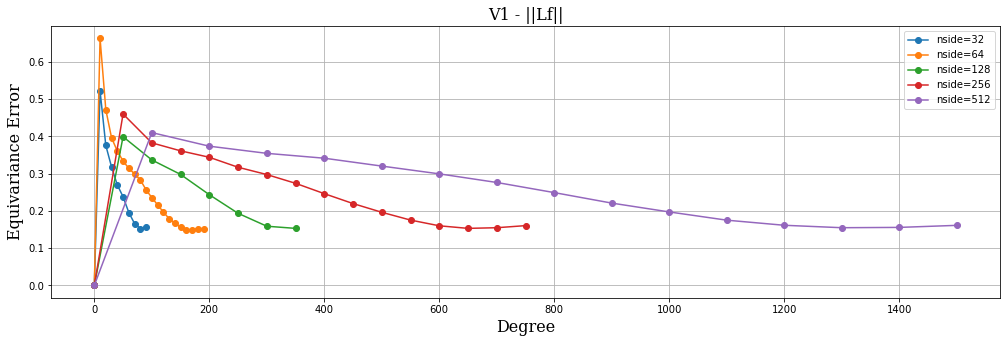

In [15]:
#plot_equivariance_error_by_degree(graph='V1', title='V1 - ||Lf||', nsides=nsides, save=True)
plot_equivariance_error_by_degree(graph='V1', title='V1 - ||Lf||', nsides=nsides, save=False)

### 3.2) DeepSphere V2 
__40 neighbors__

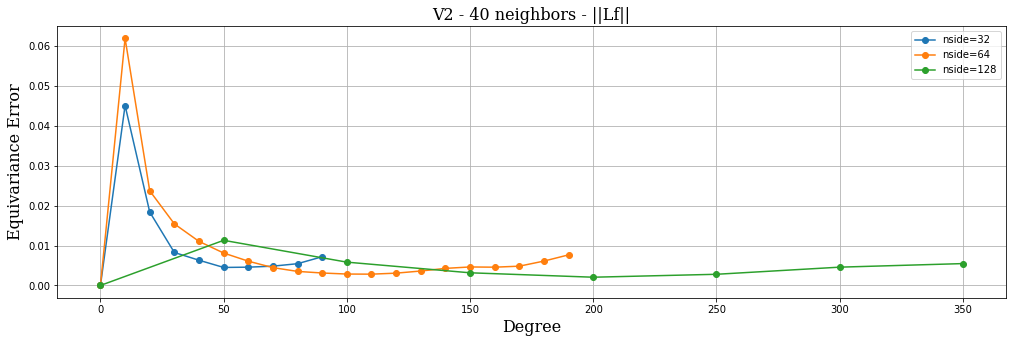

In [29]:
plot_equivariance_error_by_degree(graph='V2', n_neighbors=40, save=False, title='V2 - 40 neighbors - ||Lf||', nsides=nsides)

__20 neighbors__

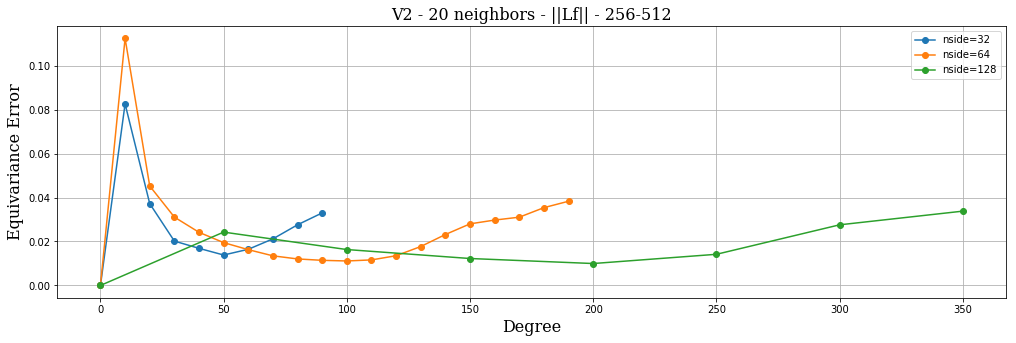

In [31]:
plot_equivariance_error_by_degree(graph='V2', n_neighbors=20, save=False, title='V2 - 20 neighbors - ||Lf|| - 256-512', nsides=nsides)

__8 neighbors__

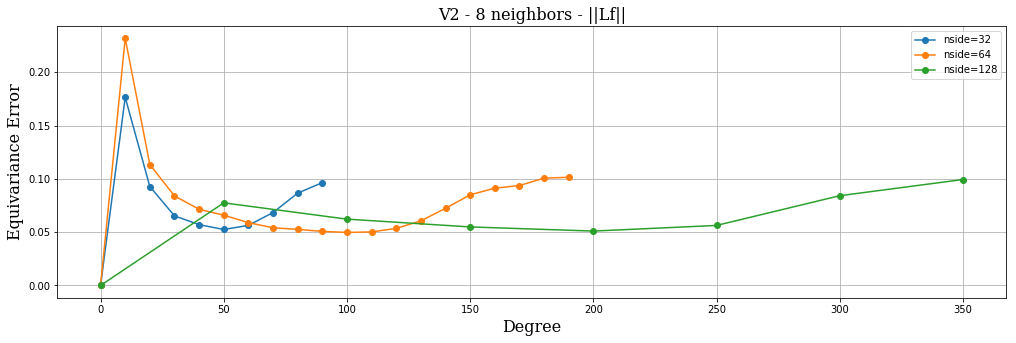

In [32]:
plot_equivariance_error_by_degree(graph='V2', n_neighbors=8, save=False, title='V2 - 8 neighbors - ||Lf||')

# 4) Equivariance error of Khasanova-Frossard

In [35]:
from pygsp.graphs import SphereEquiangular

In [76]:
def _equivariance_error(clm, max_iter, _filter, plot, save, z_axis_only=False, x_axis_only=False):
    """Calculates the equivariance error on one signal  only
    as average of max_iter random rotations"""
    
    angles = np.random.uniform(low=0, high=360, size=(max_iter, 3))
    grid = clm.expand(grid='DH')
    F_grid = _filter(grid)
    F_clm = F_grid.expand()

    norm = np.zeros(max_iter)
    for i, [alpha, beta, gamma] in enumerate(angles):
        if z_axis_only:    
            RF_clm = F_clm.rotate(alpha, 0, 0, degrees=True)
            clm_rotated = clm.rotate(alpha, 0, 0, degrees=True)
        elif x_axis_only:
            RF_clm = F_clm.rotate(0, 0, gamma, degrees=True)
            clm_rotated = clm.rotate(0, 0, gamma, degrees=True)
        else:
            clm_rotated = clm.rotate(alpha, beta, gamma, degrees=True)
            RF_clm = F_clm.rotate(alpha, beta, gamma, degrees=True)
        
        RF_data = RF_clm.expand(grid='DH').data.flatten()
        grid_rotated = clm_rotated.expand(grid='DH')
        FR_clm = _filter(grid_rotated)
        FR_grid = FR_clm.expand()
        FR_data = FR_grid.expand(grid='DH').data.flatten()
        
        norm[i] = np.linalg.norm(RF_data-FR_data)
    #grid.plot()
    #plt.show()
    #FR_grid.expand(grid='DH').plot()
    #plt.show()
    #RF_clm.expand(grid='DH').plot()
    #plt.show()
    initial_norm = np.linalg.norm(F_clm.expand(grid='DH').data.flatten())
    return np.mean(norm)/(initial_norm+1e-4)


def equivariance_error(max_iter, _filter, plot=False, save=False, degree=None, z_axis_only=False, x_axis_only=False):
    """Calculates the equivariance error on max_iter signals
    with the same power spectrum as average of N random rotations each"""
    N = 5
    np.random.seed(seed=1994)
    assert(degree is not None)
    
    if degree is not None:
        assert degree < lmax
        power = np.zeros(lmax)
        power[degree] = 1
    norm = np.zeros(max_iter)
    for i in range(max_iter):
        clm = pyshtools.SHCoeffs.from_random(power)
        norm[i] = _equivariance_error(clm, N, _filter, plot, save, z_axis_only, x_axis_only)
            
    return np.mean(norm)

### 4.1) Rotations around the north-south axis

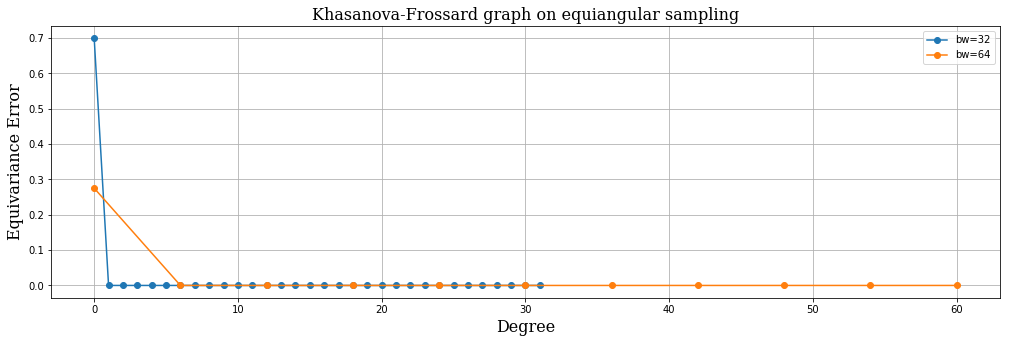

In [80]:
equiv_error = dict()
bws = [32, 64]

degree_step = {32: 1,
               64: 6,}
n_signals_to_average = 5

for bw in bws:
    lmax = bw
    
    sphere = SphereEquiangular(bandwidth=bw, lap_type='combinatorial', sampling='Driscoll-Healy')
    KF = sphere.L

    def _filter_KF(grid):
        array = grid.data
        f = array.flatten()
        ### here goes the filtering ###
        f = KF@f
        ### ----------------------- ###
        array = np.resize(f, array.shape)
        return pyshtools.SHGrid.from_array(array)
    
    degrees = np.arange(0, lmax, degree_step[bw])    
    
    equiv_error[bw] = np.zeros(len(degrees))
    for i, degree in enumerate(degrees):
        equiv_error[bw][i] = equivariance_error(n_signals_to_average, _filter_KF, plot=False, save=False, degree=degree, z_axis_only=True)
    plt.plot(degrees, equiv_error[bw], 'o-', label='bw={}'.format(bw))
    
plt.xlabel('Degree', fontdict=font)
plt.ylabel('Equivariance Error', fontdict=font)
plt.title('Khasanova-Frossard graph on equiangular sampling', fontdict=font)
plt.grid()
plt.legend()


### 4.2) Random rotations

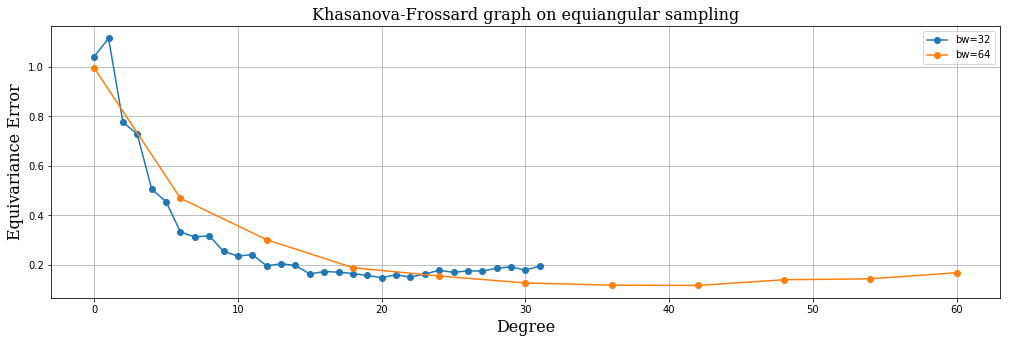

In [81]:
equiv_error = dict()

for bw in bws:
    lmax = bw
    
    sphere = SphereEquiangular(bandwidth=bw, lap_type='combinatorial', sampling='Driscoll-Healy')
    KF = sphere.L

    def _filter_KF(grid):
        array = grid.data
        f = array.flatten()
        ### here goes the filtering ###
        f = KF@f
        ### ----------------------- ###
        array = np.resize(f, array.shape)
        return pyshtools.SHGrid.from_array(array)
    
    degrees = np.arange(0, lmax, degree_step[bw])    
    
    equiv_error[bw] = np.zeros(len(degrees))
    for i, degree in enumerate(degrees):
        equiv_error[bw][i] = equivariance_error(n_signals_to_average, _filter_KF, plot=False, save=False, degree=degree)
    plt.plot(degrees, equiv_error[bw], 'o-', label='bw={}'.format(bw))
    
plt.xlabel('Degree', fontdict=font)
plt.ylabel('Equivariance Error', fontdict=font)
plt.title('Khasanova-Frossard graph on equiangular sampling', fontdict=font)
plt.grid()
plt.legend()


### 4.3) Rotations around the east-west axis

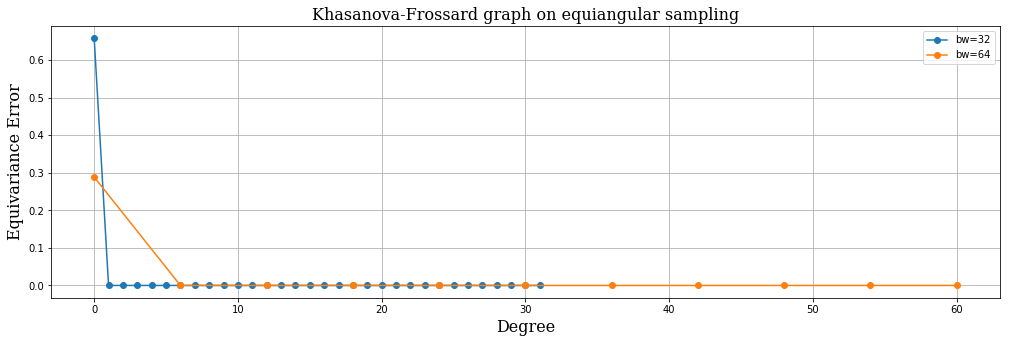

In [82]:
equiv_error = dict()

for bw in bws:
    lmax = bw
    
    sphere = SphereEquiangular(bandwidth=bw, lap_type='combinatorial', sampling='Driscoll-Healy')
    KF = sphere.L

    def _filter_KF(grid):
        array = grid.data
        f = array.flatten()
        ### here goes the filtering ###
        f = KF@f
        ### ----------------------- ###
        array = np.resize(f, array.shape)
        return pyshtools.SHGrid.from_array(array)
    
    degrees = np.arange(0, lmax, degree_step[bw])    
    
    equiv_error[bw] = np.zeros(len(degrees))
    for i, degree in enumerate(degrees):
        equiv_error[bw][i] = equivariance_error(n_signals_to_average, _filter_KF, plot=False, save=False, degree=degree, x_axis_only=True)
    plt.plot(degrees, equiv_error[bw], 'o-', label='bw={}'.format(bw))
    
plt.xlabel('Degree', fontdict=font)
plt.ylabel('Equivariance Error', fontdict=font)
plt.title('Khasanova-Frossard graph on equiangular sampling', fontdict=font)
plt.grid()
plt.legend()



# Comments:
* the error at degree=0 is due to an artefact generated close to the north pole. Still don't know why.
* why the error decreases like that for random rotations? It's the same behaviour than DeepSphere, who uses another sampling and another laplacian. What do these two architectures have in common?